In [ ]:
#====================================================================== INSTALL PRE-REQS ==================================================================
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem #Hell of an import
import pandas as pd #Importing panda as "pd"
from rdkit.Chem import AllChem
from rdkit.Chem import Draw #Import function to draw molecules
from itertools import chain
from rdkit.Chem import rdMolDescriptors
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from rdkit import Chem #Hell of an import
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef
from sklearn.externals import joblib

!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/RxnFun.py
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/QsarHelperFun.py
runfile('/content/RxnFun.py')
runfile('/content/QsarHelperFun.py')

In [3]:
#----- Upload model input data (Non-Ionic surfactant data with measured CMC values from literature)
NonIonicSurfs = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/surfactant-data/main/NonIonicSurfsLit_git_version.csv')#Upload Data  

In [4]:
#-------- define fingerprint and descriptors to use
FingerPrintType = 'Fingerprinter.FingerprintMol'
DescriptorList = ['Descriptors.MolWt','Descriptors.TPSA','Descriptors.NOCount','Descriptors.NumHAcceptors','Descriptors.NumHDonors','Descriptors.NHOHCount',
'Descriptors.NumValenceElectrons','Descriptors.NumRotatableBonds','Descriptors.MolLogP','Descriptors.MolMR','Chem.Fragments.fr_C_O','Chem.Fragments.fr_ester',
'Chem.Fragments.fr_ether','Chem.Fragments.fr_NH1','Chem.Fragments.fr_NH2','Chem.Fragments.fr_unbrch_alkane','Chem.Fragments.fr_amide']

NonIonicSurfs_Descr = CalcDescr_SMIdf(NonIonicSurfs, FingerPrintType, DescriptorList)

In [5]:
"""---------------------------------------------------------------------
1.) Build QSPR model to predict CMC of non-ionic surfactants (NI-surfs)
------------------------------------------------------------------------"""
#----- Pre-process, split data for model training/testing
Descriptors_train,  Descriptors_test,  Property_train,  Property_test = PreProcess_SMIdf(NonIonicSurfs_Descr,      
                                                                                        property_id = 'cmc_NegativeLogM', 
                                                                                        TestSize = 0.2)


#----- BUILDING MODEL Seq_cmc_1 
Seq_cmc_1 = Sequential(   
                       [Dense(units = 5, input_dim = Descriptors_train.shape[1], activation='relu'),  # 2nd layer (first hidden layer)  
                        Dense(units= 10 ,  activation='relu' ), # 3rd layer (No shape needs to be specified)
                        Dense(units= 1 ,  activation='linear' )]) # Output layer

#----- COMPILE MODEL 
Seq_cmc_1.compile(optimizer = SGD( lr=0.01, 
                                   momentum=0.9, 
                                   nesterov=True),   
                                   loss= 'mean_squared_error',    
                                   metrics = ['accuracy']) 

In [ ]:
#----- TRAIN MODEL
mod_hist = Seq_cmc_1.fit(Descriptors_train, 
                               Property_train,   
                               validation_split = 0.1,   
                               batch_size=32,   
                               epochs=500) 

In [ ]:
#------ Plot and calculate model performance
NonIonicSurfs_mod_performance = Seq_Model_performance(NonIonicSurfs_Descr, property_id = 'cmc_NegativeLogM', model = Seq_cmc_1)

In [ ]:
SubstructurePerformance = Seq_Model_performance_Substructure(SMIdf_descr = NonIonicSurfs_Descr,
                                                         property_id = 'cmc_NegativeLogM',
                                                         model =  Seq_cmc_1,                  
                                                         mol_substructure = Chem.MolFromSmarts('[#6]-[#6](-[#6])-[#6]-[#6]-[#6]-[#6](-[#6])-[#6]'))

Draw.MolsToGridImage(SubstructurePerformance.Mol, molsPerRow=9, subImgSize= (250,250), legends = list(SubstructurePerformance.Abs_error))

In [ ]:
# https://towardsdatascience.com/drug-discovery-with-graph-neural-networks-part-1-1011713185eb"""
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install --pre deepchem
import deepchem as dc
from deepchem.utils.save import load_from_disk
from deepchem.models import GraphConvModel 
dc.__version__

In [ ]:
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/GCNNhelperFun.py
runfile('/content/GCNNhelperFun.py')
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/surfactant-data/main/NonIonicSurfsLit_git_version.csv
dataset_file= "NonIonicSurfsLit_git_version.csv"

GCNN = GCNN_Model_Creator(dataset_file, "cmc_NegativeLogM", "smiles",epochs = 124, batchSize = 50 )

In [ ]:
"""___________________________________________________________________________________
2.) Generate NI-surf candidates using cheap bio-based feedstock & green chemistry
___________________________________________________________________________________"""
#----- DATA UPLOAD  
Biomass_precursors = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/surfactant-data/main/Surfactant_Precursors.csv') #Using Panda function to read the dataset
Biomass_precursor_mols = [Chem.MolFromSmiles(SMILE) for SMILE in Biomass_precursors.smiles]
Nucleophilic_Reactants = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/surfactant-data/main/Nucleophilic_Reactants.csv') 
N = [Chem.MolFromSmiles(SMILE) for SMILE in Nucleophilic_Reactants.smiles] # N = Nucleophiles
Electrophilic_reactants = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/surfactant-data/main/Electrophilic_reactants.csv')
E_total = [Chem.MolFromSmiles(SMILE) for SMILE in Electrophilic_reactants.smiles]
print("___Biomass_precursors:___\nA dataset containing algae-derived molecules that can be extracted in lab. The three functional groups being modified in this set include alcohols/alkenes (phytols) and esters (FAMEs).\n\n___Nucleophilic Reactants (N):___\nThis dataset contains alcohol and amine reactants meant to attack various electrophilic groups on the Biomass_precursors set.\n\n___Electrophilic Reactants (E_total):___\nThis set provides readily available/synthesizable epoxides and cyclic carbonates that can be opened up by nucleophilic groups\non the biomass precursors. One epoxide and one cyclic carbonate have hydroxyl functionality, allowing them to be added to the precursors via transesterification\nbefore being attacked.")

#----- Splitting data by functional group
fam = FG_split(Biomass_precursor_mols, Chem.MolFromSmarts('[#6]-[#6](-[#8])=O'), keep_group = True) # FAME precursors ('fam')
phy = FG_split(Biomass_precursor_mols, Chem.MolFromSmarts('[OH]'), keep_group = True) # Phytol precursors ('phy')
E_OH = FG_split(E_total, Chem.MolFromSmarts('[OH]'), keep_group = True)# Electrophilic reactants WITH Nucleophilic OH group ('E_OH')
E = FG_split(E_total, Chem.MolFromSmarts('[OH]'), keep_group = False) # Electrophilic reactants W/OUT Nucleophilic OH group ('E')

In [ ]:
#----- Phytol RXN Pathway 1 
phy_1 = Epoxidation(phy) #____(phy ---> phy_1)
phy_1_a = Nuc_ring_opening(phy_1, N, return_format= 'Mol') #____(phy_1 ---> phy_1_a)
phy_1_a_i = Nuc_ring_opening(E, NHOH_limit(phy_1_a, 3), return_format= 'Mol') #____(phy_1_a ---> phy_1_a_i)
phy_1_a_ii = Nuc_ring_opening(E,   NHOH_limit(phy_1_a_i, 3)   , return_format= 'Mol') #____(phy_1_a_i ---> phy_1_a_ii)
phy_1_b  = Nuc_ring_opening(phy_1, E_OH, return_format= 'Mol') # #____(phy_1 ---> phy_1_b)
phy_1_b_i = Nuc_ring_opening(phy_1_b,    N,       return_format = 'Mol')#____(phy_1_b ---> phy_1_b_i)
phy_1_b_ii = Nuc_ring_opening(E,    NHOH_limit(phy_1_b_i, 4),       return_format = 'Mol')
phy_1_c = Cyclic_Carbonation(phy_1) #____(phy_1 ---> phy_1_c)
phy_1_c_i = Nuc_ring_opening(phy_1_c, N, return_format= 'Mol') #____(phy_1_c ---> phy_1_c_i)
#phy_1_c_ii = Nuc_ring_opening(phy_1_c, phy, return_format= 'Mol') #____(phy_1_c ---> phy_1_c_ii)
#----- Phytol RXN Pathway 2 
phy_2 = Nuc_ring_opening( E_total,  phy, return_format = 'Mol')#____(phy ---> phy_2)
phy_2_a = Nuc_ring_opening( phy_2,  N, return_format = 'Mol')#____(phy_2 ---> phy_2_a)
#phy_2_b = Nuc_ring_opening( phy_2, phy, return_format = 'Mol')#____(phy_2 ---> phy_2_b)
#___________________ COMBINING Unique Products from Phytol RXN Pathway 1&2 (phy_1 & phy_2) ___________________
all_phy_products_list = [x for l in [phy_1_a,    phy_1_a_i,   phy_1_a_ii,   phy_1_b,   phy_1_b_i,   phy_1_b_ii,    phy_1_c_i,  phy_2,        phy_2_a] for x in l] #,phy_1_b_ii #phy_1_a_ii, phy_2_b phy_1_c_ii
all_phy_products_smiles = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_products_list] #Mol to Smiles
all_phy_products_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_phy_products_smiles)] #Smiles to unique Mol
all_phy_products_smiles_unique = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_products_unique] #Unique Mol to unique Smiles
#_____________________________________________________________________________________________________________
#----- FAME RXN Pathway 1 
fam_1 = fame_transesterifications(fam, N, return_format= 'Mol') #____(fam ---> fam_1)
fam_1_a = Nuc_ring_opening(E_total, NHOH_limit(fam_1, 4), return_format= 'Mol') #____(phy_1 ---> phy_1_a)
#----- FAME RXN Pathway 2 
fam_2  = fame_transesterifications(fam, E_OH, return_format= 'Mol') #____(fam ---> fam_2)
fam_2_a = Nuc_ring_opening(fam_2,  N, return_format = 'Mol')#____(fam_2 ---> fam_2_a)
fam_2_a_i = Nuc_ring_opening(E_total,  NHOH_limit(fam_2_a, 3 ), return_format = 'Mol')
fam_2_b  = fame_transesterifications(fam, NHOH_limit(fam_2,3), return_format= 'Mol') #____(fam ---> fam_2)
#___________________ COMBINING all fam_1 & fam_2 products ____________________________________________________
all_fam_list = [x for l in [fam_1, fam_1_a, fam_2_a, fam_2_a_i, fam_2_b ] for x in l] #
all_fam_smiles = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_fam_list] #Mol to Smiles
all_fam_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_fam_smiles)] #Smiles to unique Mol
all_fam_smiles_unique = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_fam_unique] #Unique Mol to unique Smiles
#_____________________________________________________________________________________________________________
#___________________ COMBINING ALL RXN PATH PRODUCTS (FAME + Phytols) ________________________________________
all_phy_fam_smiles_list = [x for l in [all_fam_smiles_unique, all_phy_products_smiles_unique ] for x in l]
all_phy_fam_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_phy_fam_smiles_list)] #Smiles to unique Mol
generated_phytolFAME_surfs = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_fam_unique] #Unique Mol to unique Smiles
#_____________________________________________________________________________________________________________
GenPHY_SMIdf = pd.DataFrame({'smiles': all_phy_products_smiles_unique})
GenFAM_SMIdf = pd.DataFrame({'smiles': all_fam_smiles_unique})
print('\n\nUnique Phytol products:',len(all_phy_products_smiles_unique))
print('Unique FAME products:',len(all_fam_smiles_unique))
print('Total unique products:',len(generated_phytolFAME_surfs))
GenMols_SMIdf = pd.DataFrame({'smiles': generated_phytolFAME_surfs}) # Turn generated smiles into dataframe
GenMols_SMIdf.head()

In [ ]:
#----Calc same descriptors used in model for newly generated molecules
GenMols_SMIdf_Descr = CalcDescr_SMIdf(GenMols_SMIdf, FingerPrintType, DescriptorList )
#----- Predict property for newly generated molecules
GenMols_SMIdf = ModelPredict_SMIdf(GenMols_SMIdf_Descr,  property_id = 'cmc_NegativeLogM',  model =  Seq_cmc_1)
GenMols_SMIdf_sorted= GenMols_SMIdf.sort_values(by='Predicted_cmc_NegativeLogM', ascending=False)
Draw.MolsToGridImage(GenMols_SMIdf_sorted.Mol.head(n=10), molsPerRow = 10, subImgSize = (250,250), legends = [str(val) for val in GenMols_SMIdf_sorted.Predicted_cmc_NegativeLogM.head(n=20)])
#Draw.MolsToGridImage(GenMols_SMIdf_sorted.Mol.tail(n=10), molsPerRow = 10, subImgSize = (250,250), legends = [str(val) for val in GenMols_SMIdf_sorted.Predicted_cmc_NegativeLogM.tail(n=20)])

In [ ]:
GenFAM_SMIdf["prop"]= (np.random.rand( GenFAM_SMIdf.shape[0]))*max(NonIonicSurfs.cmc_NegativeLogM)
GenFAM_SMIdf.to_csv('/content/GenFAM_SMIdf.csv')
dataset_file = '/content/GenFAM_SMIdf.csv'

GenFAM_preproc = GraphCNN_preprocess_modelPredict(dataset_file, smiles_field = "smiles", batchSize = 300)
GenFAM_preproc.sort_values(by = "predicted_cmc")

In [15]:
 """---------------------------------------------------------------------
3.) Build a rough estimator for Applicability Domain
---------------------------------------------------------------------"""

NonIonicSurfs_mod_performance_Descr = CalcDescr_SMIdf(NonIonicSurfs_mod_performance, FingerPrintType, DescriptorList)

# Create binary data type for predicting if model will predict a compounds accuracy within 4%
NonIonicSurfs_mod_performance_Descr['ErrLessThanMedian'] =  abs(NonIonicSurfs_mod_performance_Descr.Percent_Error) < np.median(abs(NonIonicSurfs_mod_performance_Descr.Percent_Error))

Descr_tr, Descr_ts, Prop_tr, Prop_ts  = PreProcess_SMIdf(NonIonicSurfs_mod_performance_Descr,
                                                         property_id = 'ErrLessThanMedian',
                                                         TestSize = 0.25) #----- Pre-process

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
scale = StandardScaler().fit(Descr_tr)
Descr_tr = scale.transform(Descr_tr)
# create grid search dictionary
param_grid = {"max_features": [Descr_tr.shape[1] // 10, Descr_tr.shape[1] // 7, Descr_tr.shape[1] // 5, Descr_tr.shape[1] // 3], 
              "n_estimators": [100, 250, 500]}
RFC_MedError = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=2, cv=cv, verbose=1) # setup model building
RFC_MedError.fit(Descr_tr, Prop_tr)# run modsel building
print('best params', RFC_MedError.best_params_)
print('best score:',RFC_MedError.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.4s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   24.2s finished


best params {'max_features': 9, 'n_estimators': 250}
best score: 0.8208556149732621


In [16]:
# Use Applicability Domain estimation to sort generated molecules for those with highest probability of having less than 4% error for predicted CMC

Gen_mol_Desc_array_scaled = scale.transform(np.array(list(GenMols_SMIdf_sorted['Descriptors']))) #Creating NUMPY array for descriptors & scaling
pred = RFC_MedError.predict(Gen_mol_Desc_array_scaled)
pred_prob = RFC_MedError.predict_proba(Gen_mol_Desc_array_scaled)
threshold = np.amax(pred_prob*.90)
da = np.amax(pred_prob, axis=1) > threshold
pred_prob_err = pd.DataFrame(pred_prob, columns = ['ProbabilityThatErrOverMedian', 'ProbabilityThatErrUnderMedian'])
GenMols_SMIdf_sorted["ProbabilityThatErrOverMedian"] = pred_prob_err.ProbabilityThatErrOverMedian.values
GenMols_SMIdf_sorted["ProbabilityThatErrUnderMedian"] = pred_prob_err.ProbabilityThatErrUnderMedian.values


GenMols_SMIdf_sorted["Err_UnderMedian"] = pred
GenMols_SMIdf_sorted = GenMols_SMIdf_sorted[da]
#GenMols_SMIdf_least_error = GenMols_SMIdf_sorted[GenMols_SMIdf_sorted.ModelVerdict_MoreThan4perc ==False]
sorted = GenMols_SMIdf_sorted.sort_values(by='ProbabilityThatErrUnderMedian', ascending=False)

print(sum(sorted.Err_UnderMedian))
sorted

0


,smiles,Mol,Descriptors,Predicted_cmc_NegativeLogM,ProbabilityThatErrOverMedian,ProbabilityThatErrUnderMedian,Err_UnderMedian
228,CCCCCCCC(=O)OCC(O)COC(=O)OCN(CO)COC(=O)OCC(O)C...,<rdkit.Chem.rdchem.Mol object at 0x7fab0dee2530>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 13.0,...",2.725934,0.688,0.312,False
1101,CC(C)=CCOC(=O)OC1COC(C(CO)OC(=O)OCC(O)C(O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7fab0d79e120>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 5.0, ...",2.263817,0.688,0.312,False
5564,CCCCCCCC(=O)OCC(CO)OC(=O)OC(CO)CNCCO,<rdkit.Chem.rdchem.Mol object at 0x7fab0d777d00>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 12.0,...",2.037060,0.688,0.312,False
10331,CCCCCCCC(=O)OCC(O)COC(=O)OCCNC(CO)CO,<rdkit.Chem.rdchem.Mol object at 0x7fab0d7576c0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 12.0,...",2.037060,0.688,0.312,False
7351,CCCCCCCC(=O)OCC(CNCCO)OC(=O)OC(CO)CO,<rdkit.Chem.rdchem.Mol object at 0x7fab0d71bb20>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 12.0,...",2.037060,0.688,0.312,False
...,...,...,...,...,...,...,...
483,CC(C)(OCCNC(=O)OC1C(O)COC1C1COC(=O)O1)C(O)COC(...,<rdkit.Chem.rdchem.Mol object at 0x7fab0d80eb20>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 7.0, ...",2.799620,0.760,0.240,False
9647,CC(C)(O)C(COC(=O)OCC(O)C1OCC2OC(=O)OC21)OCCNC(...,<rdkit.Chem.rdchem.Mol object at 0x7fab0d7499e0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 7.0, ...",2.799620,0.760,0.240,False
287,CC(C)(OCCNC(=O)OC(CO)C1OCC2OC(=O)OC21)C(O)COC(...,<rdkit.Chem.rdchem.Mol object at 0x7fab63334300>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 7.0, ...",2.799620,0.760,0.240,False
3541,CC(C)(OCCNC(=O)OC1COC(C2COC(=O)O2)C1O)C(O)COC(...,<rdkit.Chem.rdchem.Mol object at 0x7fab0d7cf0d0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 7.0, ...",2.799620,0.760,0.240,False


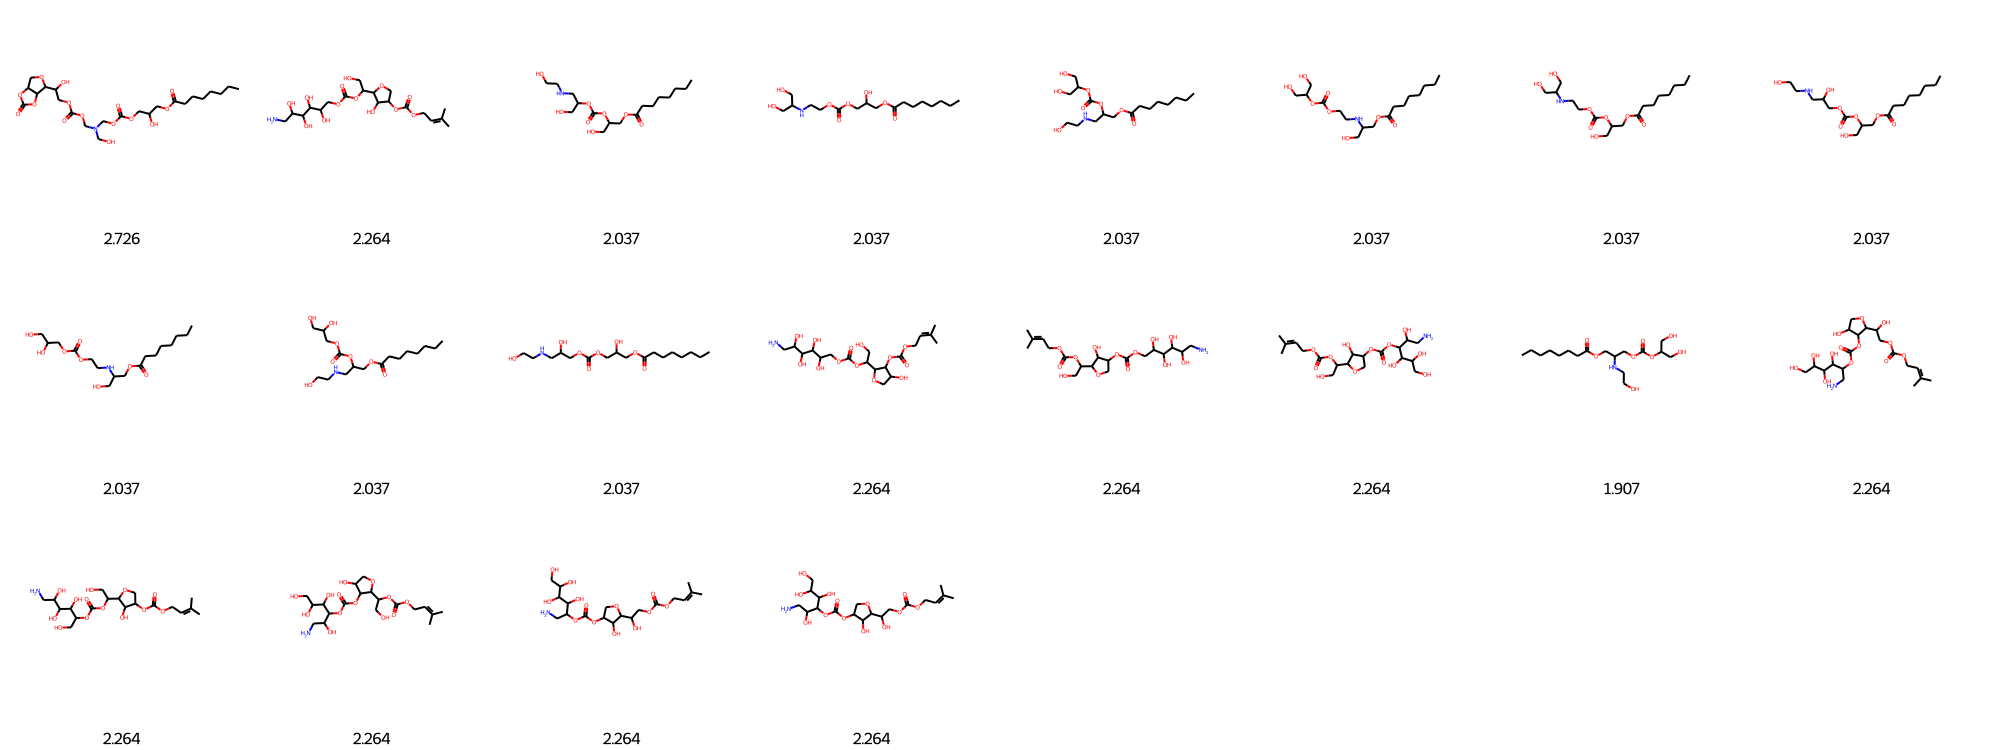

In [17]:
Draw.MolsToGridImage(sorted.Mol.head(n=20), molsPerRow = 8, subImgSize = (250,250), legends = [str(round(val,3)) for val in sorted.Predicted_cmc_NegativeLogM.head(n=20)])

In [18]:
"""
END... for now
"""

'\nEND... for now\n'

In [ ]:
"""
experimental AD clustering
https://www.macinchem.org/reviews/clustering/clustering.php
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import MACCSkeys
def ClusterFps(fps, metric, cutoff):
    dists = []     # first generate the distance matrix:
    nfps = len(fps)
    matrix = []
    for i in range(1,nfps):
        func = metrics[metric]
        sims = func(fps[i],fps[:i])
        dists.extend([1-x for x in sims])
        matrix.append(sims)
    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs,dists,matrix
def GetDistance(idx1, idx2, distances):
    idx = 0
    for i in range(1, idx1):
        idx += i
    idx += idx2
    d = distances[idx]
    #utils.log("DIST",idx1,idx2,idx,d)
    return d
#model_data_fingerprints = [Fingerprinter.FingerprintMol(mol) for mol in NonIonicSurfs.Mol]
def returnMostSim(Gen_SMIdf, training_dataset, training_mol_num):
  FAMsmiles=list(Gen_SMIdf.smiles)
  Gen_df= FAMsmiles + [training_dataset.smiles[training_mol_num]]
  len(Gen_df)
  Gen_df_Mol = [Chem.MolFromSmiles(smi) for smi in Gen_df]
  model_data_fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol,2,1024) for mol in Gen_df_Mol]
  clusters, distances, matrix=ClusterFps(model_data_fingerprints, metric = 'tanimoto',cutoff=0.05)
  mol_numbs = range(0, len(Gen_df_Mol))
  mol_of_interest = len(Gen_df_Mol)
  dist_list= [GetDistance(mol_of_interest, mol, distances) for mol in mol_numbs]
  #distances_to_mol_1 = pd.DataFrame({'mol#': mol_numbs, "dist_to_mol_1": dist_list})
  #dist_1_sorted = distances_to_mol_1.sort_values(by = 'dist_to_mol_1', ascending=True)
  #mols = [Gen_df_Mol[mol] for mol in dist_1_sorted['mol#'][1:25]]
  #print(dist_1_sorted[1:25])
  return dist_list #Draw.MolsToGridImage(mols,  molsPerRow = 10, subImgSize = (350,350), legends = [str(val) for val in dist_1_sorted['mol#'][1:25] ])
Draw.MolToImage(NonIonicSurfs_Descr.Mol[150])
#Gen_df = pd.concat([GenFAM_SMIdf.smiles.values+ NonIonicSurfs_Descr.smiles[150]])
#smi=str(NonIonicSurfs_Descr.smiles[151])
#Gen_df = FAMsmiles.extend(smi)
#Gen_df = pd.DataFrame(FAMsmiles.append(smi))
#Gen_df = [x in l for Gen_df]
#len(GenFAM_SMIdf.smiles.values)
returnMostSim(GenFAM_SMIdf[:200], NonIonicSurfs_Descr, 150)
"""